In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000) 
pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
script_dir = Path.cwd()

baseTablePath = script_dir.parent/"data"/"analysis_base.csv"
myDataFrame = pd.read_csv(baseTablePath)
myDataFrame.head()

,seqn,age_years,age_group,sex,race_eth,educ_level,pir,mcq220,ever_cancer,dpq_total,dpq_cat,smoke_status,hscrp_mg_l_raw,hscrp_cat,early_onset_proxy
0,130383,3.0,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130556,15.0,NaN,2,3,NaN,1.57,NaN,NaN,NaN,NaN,NaN,38365.256625,high,NaN
2,130648,12.0,NaN,2,3,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131008,12.0,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131478,1.0,NaN,1,4,NaN,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df = myDataFrame.dropna(subset=["ever_cancer","age_group","smoke_status","dpq_total","mcq220"])
df.reset_index(drop=True, inplace=True)
df.head()

,seqn,age_years,age_group,sex,race_eth,educ_level,pir,mcq220,ever_cancer,dpq_total,dpq_cat,smoke_status,hscrp_mg_l_raw,hscrp_cat,early_onset_proxy
0,130379,66.0,60+,1,3,5.0,5.00,1.0,1.0,1.000000e+00,none-minimal,former,37435.705647,high,0.0
1,130380,44.0,40-49,2,2,3.0,1.41,2.0,0.0,2.000000e+00,none-minimal,never,85328.844519,high,NaN
2,130386,34.0,30-39,1,1,4.0,1.33,2.0,0.0,1.000000e+00,none-minimal,former,44526.214135,high,NaN
3,130387,68.0,60+,2,3,5.0,1.32,1.0,1.0,4.857845e-78,none-minimal,never,22746.296353,high,0.0
4,130389,59.0,50-59,1,3,5.0,5.00,2.0,0.0,4.857845e-78,none-minimal,former,40905.058765,high,NaN


In [19]:
def zscore(series):
    s = pd.to_numeric(series, errors="coerce")
    m  = np.nanmean(s)
    sd = np.nanstd(s, ddof=1)
    return (s - m) / sd if np.isfinite(sd) and sd != 0 else s

if "dpq_total" in df.columns:
    df["dpq_total_std"] = zscore(df["dpq_total"])
if "log_hscrp" in df.columns:
    df["log_hscrp_std"] = zscore(df["log_hscrp"])

for col in ["smoke_status", "dpq_cat", "hscrp_cat", "sex", "educ_level"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

if "age_years" not in df.columns:
    raise ValueError("Missing 'age_years' to create subgroups.")

if "log_hscrp_std" not in df.columns and "hscrp_mg_l_raw" in df.columns:
    crpTmp = pd.to_numeric(df["hscrp_mg_l_raw"], errors="coerce").clip(lower=0)
    df["log_hscrp"] = np.log1p(crpTmp)
    df["log_hscrp_std"] = zscore(df["log_hscrp"])

In [20]:
df_under50 = df[pd.to_numeric(df["age_years"], errors="coerce") < 50].copy()
df_over50  = df[pd.to_numeric(df["age_years"], errors="coerce") >= 50].copy()

print(f"Under-50 rows: {len(df_under50)}")
print(f"Over 50+ rows:      {len(df_over50)}")

Under-50 rows: 2009
Over 50+ rows:      3188


#### Plots and models


In [17]:
def save_barplot(myDataFrame_sub, x, hue, title):
    if x not in myDataFrame_sub.columns or hue not in myDataFrame_sub.columns:
        return
    ctab = pd.crosstab(myDataFrame_sub[x], myDataFrame_sub[hue])
    ax = ctab.plot(kind="bar", figsize=(7,4))
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.plot()

def forest_from_or(or_myDataFrame, tag):
    plot_myDataFrame = or_myDataFrame[or_myDataFrame["term"] != "Intercept"].copy()
    x = plot_myDataFrame["OR"].values
    y = np.arange(len(plot_myDataFrame))
    labels = plot_myDataFrame["term"].values
    plt.figure(figsize=(7,4))
    plt.scatter(x, y)
    plt.axvline(1.0, color="red", linestyle="--", linewidth=1)
    plt.yticks(y, labels)
    plt.xscale("log")
    plt.xlabel("Odds Ratio (log scale)")
    plt.title(f"Odds Ratios ({tag})")
    plt.tight_layout()
    plt.close()

In [62]:

def fit_logit_ridge(myDataFrame_sub, formula, used_cols, tag, show_plots= False):
    need = [c for c in used_cols if c not in myDataFrame_sub.columns]

    if "early_onset_proxy" in used_cols:
        outcome_col = "early_onset_proxy"
    else:
        outcome_col = "ever_cancer"

    if need:
        print(f"[Skip] {tag}: missing columns {need}")
        return None, None, None

    d = myDataFrame_sub.dropna(subset=used_cols).copy()
    y = pd.to_numeric(d[outcome_col], errors="coerce")
    d = d[y.isin([0,1])].copy()

    if d[outcome_col].nunique() < 2 or len(d) < 30:
        print(f"[Skip] {tag}: not enough variation or rows (n={len(d)}).")
        return None, None, None

    # Ridge-regularized logistic (L2)
    alpha = 1.0
    model = smf.logit(formula, data=d).fit_regularized(maxiter=500, alpha=alpha, L1_wt=0.0)

    # OR table 
    params = model.params
    or_myDataFrame = pd.DataFrame({"term": params.index, "OR": np.exp(params)})
    try:
        ci = model.conf_int()
        or_myDataFrame["CI_lower"] = np.exp(ci[0])
        or_myDataFrame["CI_upper"] = np.exp(ci[1])
    except Exception:
        pass
    or_myDataFrame = or_myDataFrame.round(3)
    

    # Predictions & plots
    y_true = d[outcome_col].astype(int).values
    y_hat  = model.predict(d).values

    auc = roc_auc_score(y_true, y_hat)
    nobs = int(getattr(model, "nobs", len(d)))
    summary = [
        f"Tag: {tag}",
        f"Formula: {formula}",
        f"Rows used: {nobs}",
        f"Ridge alpha: {alpha}",
        f"AUC: {auc if np.isfinite(auc) else 'NA'}"
    ]
    print(f"[Done] {tag}: n={nobs}, AUC={auc if np.isfinite(auc) else 'NA'}")
    display(or_myDataFrame)

    if show_plots:

        # Pred vs actual (jittered)
        yj = y_true + (np.random.rand(len(y_true)) - 0.5) * 0.05
        plt.figure(figsize=(6,4))
        plt.scatter(y_hat, yj, alpha=0.5)
        plt.yticks([0,1], ["Actual: 0", "Actual: 1"])
        plt.xlabel("Predicted probability")
        plt.ylabel("Actual (jittered)")
        plt.title(f"Predicted vs Actual ({tag})")
        plt.tight_layout()
        plt.plot()


        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_hat)
        auc = roc_auc_score(y_true, y_hat)
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
        plt.plot([0,1],[0,1], 'k--', lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({tag})")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.plot()
 
    return model, or_myDataFrame, auc

In [63]:
df_u50_cases = df[(df["age_years"] < 50) & (df["ever_cancer"] == 1)].copy()

for col in ["sex", "race_eth", "educ_level", "smoke_status"]:
    print(col, df_u50_cases[col].nunique())  

model_case_simple = smf.logit(
    "early_onset_proxy ~ dpq_total_std + log_hscrp_std + pir + C(sex) + C(smoke_status)",
    data=df_u50_cases
).fit(disp=False)

print(model_case_simple.summary())


sex 2
race_eth 6
educ_level 5
smoke_status 3
                           Logit Regression Results                           
Dep. Variable:      early_onset_proxy   No. Observations:                   45
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 Sep 2025   Pseudo R-squ.:                     inf
Time:                        15:47:23   Log-Likelihood:            -1.0137e-07
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    22.9286    2.6e+04      0.001      0.999    -5.1e+04     5.1e+04
C(sex)[T.2]                   1.2773    1

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22205969594553185
            Iterations: 116
            Function evaluations: 116
            Gradient evaluations: 116
[Done] Case-only: early vs late cancer: n=707, AUC=0.7390063779791877


,term,OR,CI_lower,CI_upper
Intercept,Intercept,0.249,0.075,0.827
C(smoke_status)[T.former],C(smoke_status)[T.former],0.231,0.084,0.632
C(smoke_status)[T.never],C(smoke_status)[T.never],0.624,0.268,1.452
C(sex)[T.2],C(sex)[T.2],1.000,NaN,NaN
C(educ_level)[T.2.0],C(educ_level)[T.2.0],1.000,NaN,NaN
C(educ_level)[T.3.0],C(educ_level)[T.3.0],0.412,0.148,1.146
C(educ_level)[T.4.0],C(educ_level)[T.4.0],1.041,0.527,2.058
C(educ_level)[T.5.0],C(educ_level)[T.5.0],1.000,NaN,NaN
C(educ_level)[T.9.0],C(educ_level)[T.9.0],1.000,NaN,NaN
C(race_eth)[T.2],C(race_eth)[T.2],1.000,NaN,NaN


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11743938025447939
            Iterations: 176
            Function evaluations: 176
            Gradient evaluations: 176
[Done] interaction: n=1757, AUC=0.6979620976116303


,term,OR,CI_lower,CI_upper
Intercept,Intercept,0.029,0.009,0.090
C(sex)[T.2],C(sex)[T.2],1.228,0.640,2.355
C(smoke_status)[T.former],C(smoke_status)[T.former],0.518,0.198,1.358
C(smoke_status)[T.never],C(smoke_status)[T.never],0.531,0.242,1.163
C(educ_level)[T.2.0],C(educ_level)[T.2.0],1.000,NaN,NaN
C(educ_level)[T.3.0],C(educ_level)[T.3.0],0.477,0.175,1.299
C(educ_level)[T.4.0],C(educ_level)[T.4.0],1.000,NaN,NaN
C(educ_level)[T.5.0],C(educ_level)[T.5.0],0.984,0.475,2.038
C(educ_level)[T.9.0],C(educ_level)[T.9.0],1.000,NaN,NaN
C(race_eth)[T.2],C(race_eth)[T.2],0.956,0.264,3.467


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11840406139304117
            Iterations: 166
            Function evaluations: 166
            Gradient evaluations: 166
[Done] lifestyle covariates (smoking, BMI if available, PIR): n=1757, AUC=0.6902647975077881


,term,OR,CI_lower,CI_upper
Intercept,Intercept,0.033,0.011,0.099
C(smoke_status)[T.former],C(smoke_status)[T.former],0.550,0.211,1.431
C(smoke_status)[T.never],C(smoke_status)[T.never],0.567,0.261,1.231
C(educ_level)[T.2.0],C(educ_level)[T.2.0],1.000,NaN,NaN
C(educ_level)[T.3.0],C(educ_level)[T.3.0],0.473,0.175,1.280
C(educ_level)[T.4.0],C(educ_level)[T.4.0],1.000,NaN,NaN
C(educ_level)[T.5.0],C(educ_level)[T.5.0],0.972,0.473,2.000
C(educ_level)[T.9.0],C(educ_level)[T.9.0],1.000,NaN,NaN
C(race_eth)[T.2],C(race_eth)[T.2],0.970,0.269,3.501
C(race_eth)[T.3],C(race_eth)[T.3],1.433,0.580,3.544


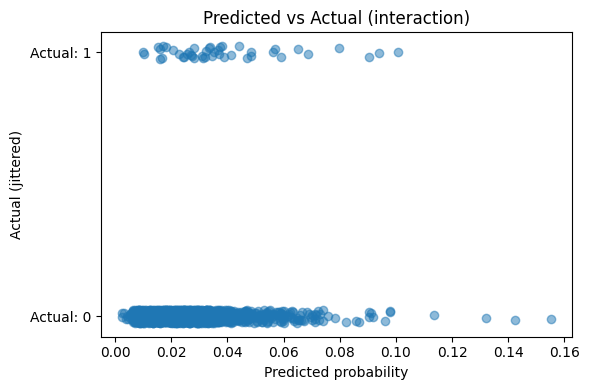

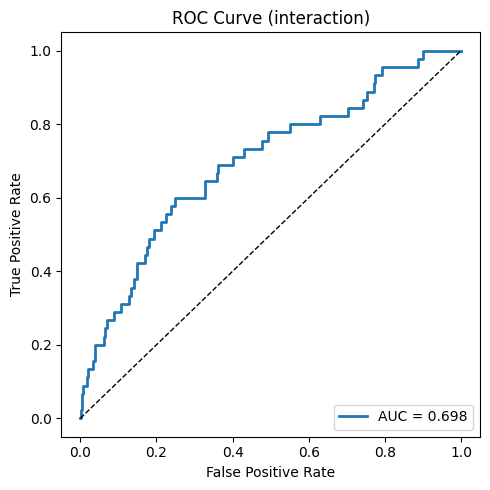

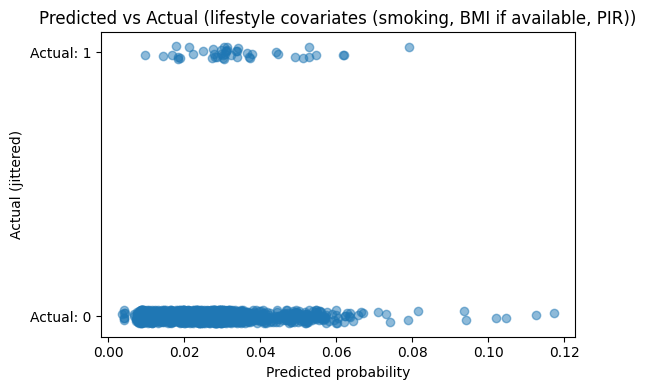

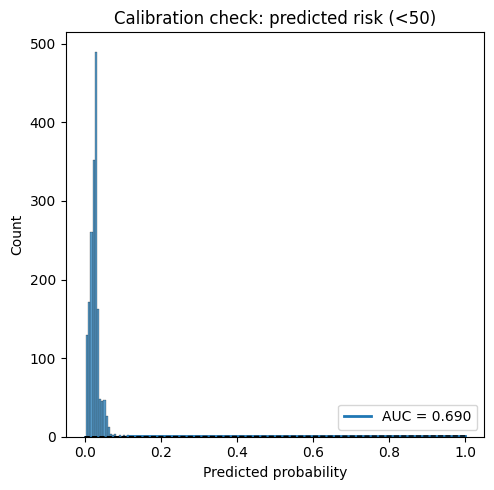

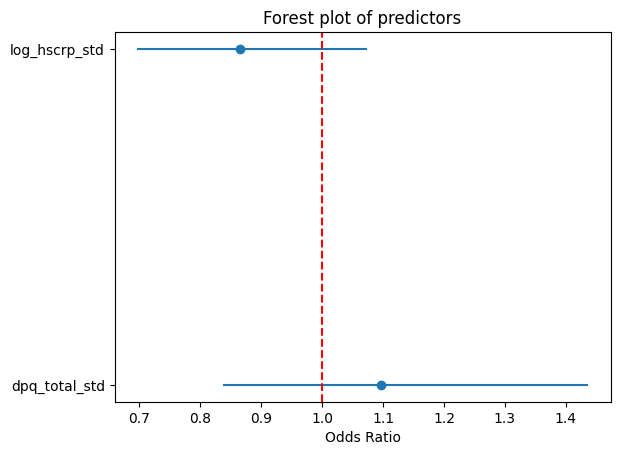

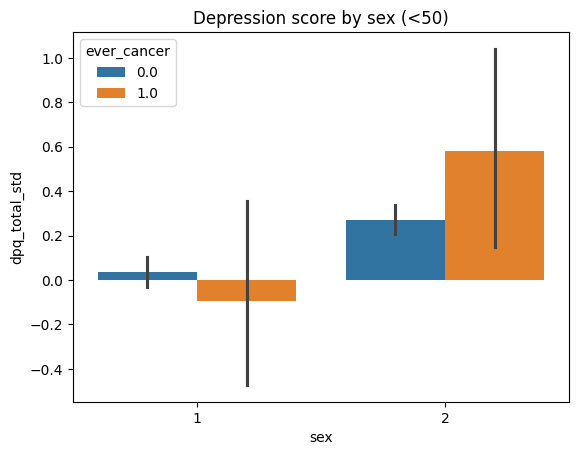

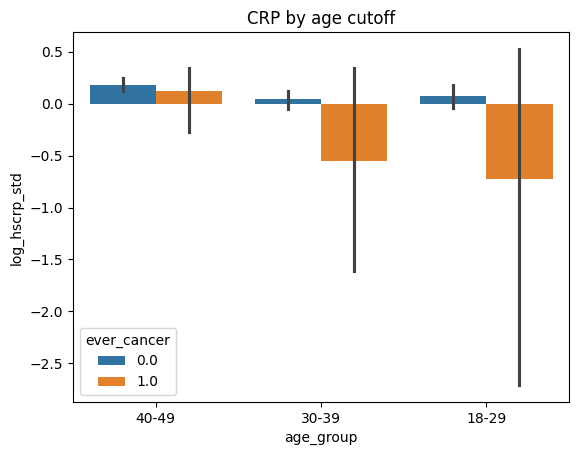

In [64]:

import seaborn as sns
from statsmodels.stats.diagnostic import linear_harvey_collier

df_u50_sens = df_under50[df_under50["hscrp_mg_l_raw"] <= 10]  

formula = "early_onset_proxy ~ dpq_total_std + log_hscrp_std + pir + C(smoke_status) + C(sex) + C(educ_level) + C(race_eth)"
used_cols = ["early_onset_proxy" , "dpq_total_std" , "log_hscrp_std", "pir" ,"smoke_status" ,"sex", "educ_level", "race_eth", "ever_cancer"]
model_case, case_df_summ, auc_case = fit_logit_ridge(df,formula, used_cols, "Case-only: early vs late cancer")

formula = "ever_cancer ~ dpq_total_std*C(sex) + log_hscrp_std*C(sex) + pir + C(smoke_status) + C(educ_level) + C(race_eth)"
used_cols = ["ever_cancer", "dpq_total_std", "sex", "log_hscrp_std", "pir", "smoke_status", "educ_level" , "race_eth"]

model_interact, interact_df_summ, auc_interact = fit_logit_ridge(df_under50, formula, used_cols, "interaction",show_plots=True)


formula = "ever_cancer ~ dpq_total_std + log_hscrp_std + pir + C(smoke_status) + C(educ_level) + C(race_eth)"
used_cols = ["ever_cancer", "dpq_total_std", "log_hscrp_std", "pir", "smoke_status", "educ_level", "race_eth"]

model_life , life_summ_df, auc_life = fit_logit_ridge(df_under50, formula, used_cols, "lifestyle covariates (smoking, BMI if available, PIR)", show_plots=True)

preds = model_life.predict(df_under50)
sns.histplot(preds, bins=20, kde=False)
plt.title("Calibration check: predicted risk (<50)")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.show()

def plot_forest(model, vars_to_plot):
    OR = model.params[vars_to_plot].apply(lambda x: np.exp(x))
    CI = model.conf_int().loc[vars_to_plot].apply(np.exp)
    plt.errorbar(OR, vars_to_plot, xerr=[OR-CI[0], CI[1]-OR], fmt='o')
    plt.axvline(1, color="red", linestyle="--")
    plt.xlabel("Odds Ratio")
    plt.title("Forest plot of predictors")
    plt.show()

plot_forest(model_life, ["dpq_total_std","log_hscrp_std"])

sns.barplot(x="sex", y="dpq_total_std", hue="ever_cancer", data=df_under50)
plt.title("Depression score by sex (<50)")
plt.show()

sns.barplot(x="age_group", y="log_hscrp_std", hue="ever_cancer", data=df_under50)
plt.title("CRP by age cutoff")
plt.show()
